# Importing Libraries

In [1]:
import pandas as pd
pd.options.display.max_columns = None
import numpy as np
import matplotlib.pyplot as plt
from brokenaxes import brokenaxes 
from IPython import display
from IPython.display import Image
import utm
from imblearn.over_sampling import SMOTE

# Data Loading & Handling

## Data Loading / Wrangling Pipeline

In [2]:
def data_pipeline(years=[2018,2019,2020,2021]):
    
    ### LOAD ORIGINAL DATA ###
    base_string = r"data\raw_data_Strassenverkehrsunfaelle\AfSBBB_BE_LOR_Strasse_Strassenverkehrsunfaelle_XXXX_Datensatz.csv"
    csv_file_path = [base_string.replace("XXXX", str(y)) for y in years]
    
    data_all = pd.DataFrame() # create empty dataframe to append yearly dataframes to 
    
    ### DATA WRANGLING ###
    for csv in csv_file_path:
        df = pd.read_csv(csv, sep=";", encoding = 'latin1')
        
        ### MAKE COLUMNS LOWERCASE ###
        df.columns = [col.lower() for col in df.columns]
        
        ### REPLACE DECIMAL COMMA TO DOT
        df["linrefx"] = list(map(lambda x: x.replace(",", "."), df["linrefx"]))
        df["linrefy"] = list(map(lambda x: x.replace(",", "."), df["linrefy"]))
        df["xgcswgs84"] = list(map(lambda x: x.replace(",", "."), df["xgcswgs84"]))
        df["ygcswgs84"] = list(map(lambda x: x.replace(",", "."), df["ygcswgs84"]))
        
        ### RENAME GCSWGS COLUMNS ###
        if "2018" in csv: # if data from 2018, then rename two columns additionally to match later data
            df.rename(columns={"istsonstig": "istsonstige", "strzustand": "ustrzustand"}, inplace=True)
        df.rename(columns={"xgcswgs84": "long", "ygcswgs84": "lat"}, inplace=True)
        
        data_all = pd.concat([data_all, df], axis=0)
        data_all.reset_index(drop=True, inplace=True)

    return data_all

data_all = data_pipeline()
data18 = data_pipeline(["2018"])
data19 = data_pipeline(["2019"])
data20 = data_pipeline(["2020"])
data21 = data_pipeline(["2021"])

In [3]:
rename_days = {1: 7, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6}

data_all["uwochentag"] = [rename_days[day] if day in rename_days.keys()
                          else day
                          for day in data_all["uwochentag"] ]

In [4]:
data_all

,objectid,land,bez,lor,strasse,lor_ab_2021,ujahr,umonat,ustunde,uwochentag,ukategorie,uart,utyp1,ulichtverh,istrad,istpkw,istfuss,istkrad,istgkfz,istsonstige,ustrzustand,linrefx,linrefy,long,lat
0,112695,11,2,2050602.0,Samariterviertel,2500729.0,2018,1,15,3,3,6,4,0,0,1,1,0,0,0,1,803604.1562,5827580.738,13.4750178,52.51359681
1,112705,11,12,12304314.0,Ziekowstraße/Freie Scholle,12500824.0,2018,1,11,1,3,2,6,0,0,1,0,0,0,0,0,790639.5854,5835009.589,13.29102205,52.58725906
2,112726,11,2,2040501.0,Barnimkiez,2400520.0,2018,1,9,2,3,6,4,0,0,1,1,0,0,0,0,799827.9618,5828733.523,13.42057818,52.52601854
3,112737,11,7,7020202.0,Volkspark (Rudolf-Wilde-Park),7200308.0,2018,1,17,1,3,6,7,2,0,1,1,0,0,0,0,795223.509,5823525.402,13.34828776,52.48184447
4,112747,11,3,3020209.0,Niederschönhausen,3200206.0,2018,1,15,3,3,6,7,1,1,0,1,0,0,0,1,798261.3849,5835047.26,13.40322797,52.58347154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50113,112174,11,4,NaN,NaN,4300414.0,2021,3,16,3,3,6,2,0,0,1,1,0,0,0,1,791505.4105,5826555.664,13.29634478,52.51100814
50114,111541,11,4,NaN,NaN,4400726.0,2021,1,1,5,3,9,1,2,0,1,0,0,0,0,0,791154.679,5824616.757,13.28949592,52.49381321
50115,110370,11,3,NaN,NaN,2400520.0,2021,1,20,7,3,3,6,2,0,1,0,0,0,0,1,799988.2122,5828912.431,13.42309463,52.52753402
50116,109998,11,7,NaN,NaN,7300619.0,2021,1,14,6,3,2,6,0,0,1,0,0,0,0,1,796018.2589,5822739.196,13.35925879,52.47436651


## Save Dataframe to csv

## Load Original Data

## Make Columns Lowercase

## Replace decimal marker (comma -> dot)

## Rename `_gcswgs84` columns

# Explanations

# Initial EDA

## Checking NaN distribution in features in `data_all`

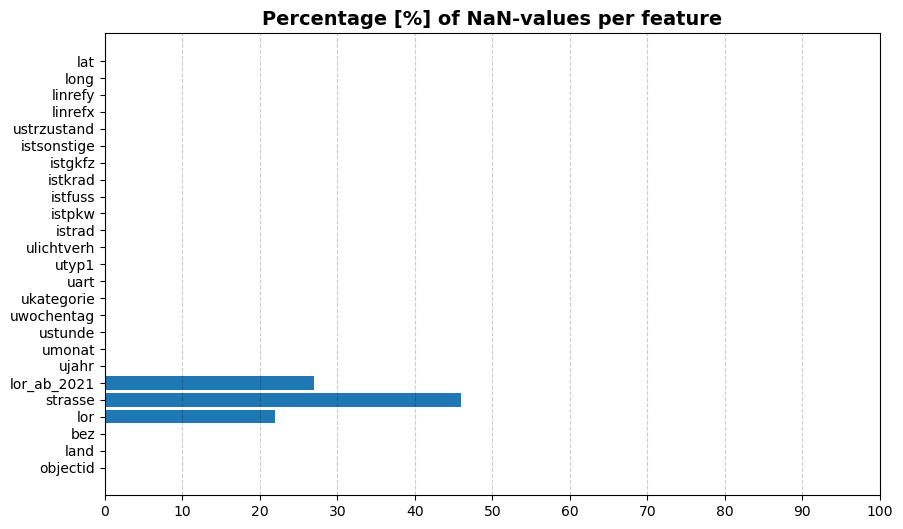

In [5]:
feature_nan_perc = [int(round((data_all[col].isna().sum() / len(data_all[col])*100),0)) 
                    for col in list(data_all.columns)]

fig, ax = plt.subplots(figsize=(10,6))
plt.title("Percentage [%] of NaN-values per feature", size=14, weight="bold")
plt.grid(ls="--", color="k", alpha=0.2, axis="x")
plt.barh(data_all.columns, feature_nan_perc)
plt.xticks(np.arange(0,101,10))

plt.show()

## Explore data21

### Check feature uniques

- accidents by:
    - type / kind / category
    - borough
    - month / day / time

In [6]:
data21

,objectid,land,bez,lor_ab_2021,ujahr,umonat,ustunde,uwochentag,ukategorie,uart,utyp1,ulichtverh,istrad,istpkw,istfuss,istkrad,istgkfz,istsonstige,ustrzustand,linrefx,linrefy,long,lat
0,219249,11,3,3701658.0,2021,11,18,2,3,0,3,2,0,1,0,1,0,0,1,800202.0742,5829640.204,13.42689483,52.53393955
1,219248,11,7,7501134.0,2021,12,19,7,3,6,2,2,0,1,1,0,0,0,1,798479.5317,5819049.219,13.39209027,52.43995086
2,219247,11,4,4100101.0,2021,12,17,4,3,5,2,2,0,1,0,0,0,0,0,793352.6128,5829680.195,13.32624193,52.53802784
3,219246,11,4,4501041.0,2021,12,15,7,3,5,2,1,0,1,0,1,0,0,1,792950.0395,5825362.081,13.31652064,52.49953417
4,219243,11,11,11501339.0,2021,12,9,5,3,3,6,0,0,1,0,0,0,1,2,807182.01,5825602.793,13.52575163,52.49386714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11262,112174,11,4,4300414.0,2021,3,16,4,3,6,2,0,0,1,1,0,0,0,1,791505.4105,5826555.664,13.29634478,52.51100814
11263,111541,11,4,4400726.0,2021,1,1,6,3,9,1,2,0,1,0,0,0,0,0,791154.679,5824616.757,13.28949592,52.49381321
11264,110370,11,3,2400520.0,2021,1,20,1,3,3,6,2,0,1,0,0,0,0,1,799988.2122,5828912.431,13.42309463,52.52753402
11265,109998,11,7,7300619.0,2021,1,14,7,3,2,6,0,0,1,0,0,0,0,1,796018.2589,5822739.196,13.35925879,52.47436651


In [7]:
#1 - "Mitte"
#2 - "Friedrichshain-Kreuzberg"
#3 - "Pankow"
#4 - "Charlottenburg-Wilmersdorf
#5 - "Spandau"
#6 - "Steglitz-Zehlendorf"
#7 - "Tempelhof-Schöneberg"
#8 - "Neukölln
#9 - "Treptow-Köpenick"
#10 - "Marzahn-Hellersdorf"
#11 - "Lichtenberg"
#12 - "Reinickendorf"

data21["bez"].value_counts().sort_index()

1     1761
2     1107
3     1011
4     1398
5      713
6      757
7     1059
8      799
9      776
10     538
11     619
12     729
Name: bez, dtype: int64

In [8]:
data21["umonat"].value_counts().sort_index()

1      481
2      436
3      765
4      720
5      991
6     1314
7     1053
8     1274
9     1300
10    1130
11    1007
12     796
Name: umonat, dtype: int64

In [9]:
#1 = Sonntag
#2 = Montag
#3 = Dienstag
#4 = Mittwoch
#5 = Donnerstag
#6 = Freitag
#7 = Samstag

data21["uwochentag"].value_counts().sort_index()

1     892
2    1786
3    1941
4    1868
5    1792
6    1781
7    1207
Name: uwochentag, dtype: int64

In [10]:
data21["ustunde"].value_counts().sort_index()

0      104
1       80
2       58
3       50
4       56
5      115
6      258
7      504
8      580
9      560
10     584
11     639
12     715
13     763
14     895
15    1031
16     951
17     915
18     788
19     572
20     379
21     276
22     229
23     165
Name: ustunde, dtype: int64

In [11]:
#1 = Unfall mit Getöteten // Accident with death
#2 = Unfall mit Schwerverletzten // Accident with severely injured 
#3 = Unfall mit Leichtverletzten // Accident with slightly injured

data21["ukategorie"].value_counts().sort_index()

1      31
2    1654
3    9582
Name: ukategorie, dtype: int64

In [12]:
#1 = Zusammenstoß mit anfahrendem/anhaltendem/ruhendem Fahrzeug // 
#2 = Zusammenstoß mit vorausfahrendem/wartendem Fahrzeug // 
#3 = Zusammenstoß mit seitlich in gleicher Richtung fahrendem Fahrzeug // 
#4 = Zusammenstoß mit entgegenkommendem Fahrzeug // 
#5 = Zusammenstoß mit einbiegendem/ kreuzendem Fahrzeug // 
#6 = Zusammenstoß zwischen Fahrzeug und Fußgänger // 
#7 = Aufprall auf Fahrbahnhindernis // 
#8 = Abkommen von Fahrbahn nach rechts // 
#9 = Abkommen von Fahrbahn nach links // 
#0 = Unfall anderer Art //

accidents_clusters = {
    "Crash with vehicle" : [1,2,3,4,5],
    "Vehicle-Person Crash" : 6,
    "Other crash" : 0,
    "Accident by Lane Departure" : [8,9],
    "Collision with Road-Object" : 7}

data21["uart"].value_counts().sort_index()

0    1537
1     943
2    2021
3     642
4     151
5    4355
6    1359
7      20
8     126
9     113
Name: uart, dtype: int64

In [13]:
#1 = Fahrunfall // 
#2 = Abbiegeunfall // 
#3 = Einbiegen / Kreuzen-Unfall // 
#4 = Überschreiten-Unfall // 
#5 = Unfall durch ruhenden Verkehr // 
#6 = Unfall im Längsverkehr // 
#7 = sonstiger Unfall // 

data21["utyp1"].value_counts().sort_index()

1     918
2    2764
3    2288
4     781
5     938
6    2449
7    1129
Name: utyp1, dtype: int64

In [14]:
#0 = Tageslicht // daylight
#1 = Dämmerung // twilight
#2 = Dunkelheit // darkness

data21["ulichtverh"].value_counts().sort_index()

0    8472
1     681
2    2114
Name: ulichtverh, dtype: int64

In [15]:
#0 = Unfall ohne Fahrradbeteiligung // Accident without bicycle 
#1 = Unfall mit Fahrradbeteiligung // Accident with bicycle

data21["istrad"].value_counts().sort_index()

0    7016
1    4251
Name: istrad, dtype: int64

In [16]:
#0 = Unfall ohne PKW-Beteiligung // Accident without car
#1 = Unfall mit PKW-Beteiligung // Accident with car

data21["istpkw"].value_counts().sort_index()

0    2229
1    9038
Name: istpkw, dtype: int64

In [17]:
#0 = Unfall ohne Kraftrad // Accident without motorcycle
#1 = Unfall mit Kraftrad // Accident with motorcycle

data21["istkrad"].value_counts().sort_index()

0    9611
1    1656
Name: istkrad, dtype: int64

In [18]:
#0 = Unfall ohne Fußgänger // Accident without pedestrian 
#1 = Unfall mit Fußgänger // Accident with pedestrian

data21["istfuss"].value_counts().sort_index()

0    9807
1    1460
Name: istfuss, dtype: int64

In [19]:
#0 = Unfall ohne LKW // Accident without truck 
#1 = Unfall mit LKW // Accident with truck

data21["istgkfz"].value_counts().sort_index()

0    10925
1      342
Name: istgkfz, dtype: int64

In [20]:
#0 = trocken // dry
#1 = nass/feucht/schlüpfrig // wet/damp/slippery
#2 = winterglatt // winter slipperiness

data21["ustrzustand"].value_counts().sort_index()

0    8407
1    2694
2     166
Name: ustrzustand, dtype: int64

### Accidents per month

In [21]:
month_number_list = sorted(list(data21["umonat"].unique()))
borough_number_list = sorted(list(data21["bez"].unique()))
accidents_per_month = [len(data21[data21["umonat"]==monat]) for monat in month_number_list]
#accidents_per_month = list(data21["umonat"].value_counts().sort_index().values)

month_list = ["January", "February", "March", "April", "May", "June", 
              "July", "August", "September", "October", "November", "December"]

borough_list = ["Mitte", "Friedrichshain-Kreuzberg", "Pankow", "Charlottenburg-Wilmersdorf",
               "Spandau", "Steglitz-Zehlendorf", "Tempelhof-Schöneberg", "Neukölln",
               "Treptow-Köpenick", "Marzahn-Hellersdorf", "Lichtenberg", "Reinickendorf"]

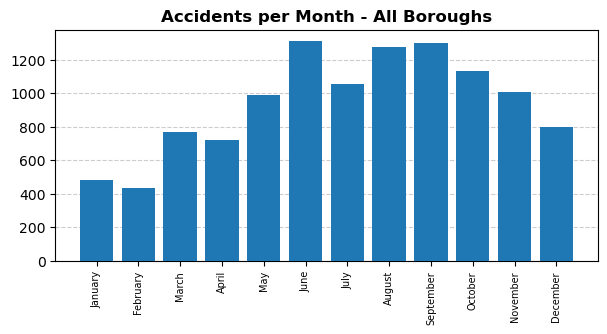

In [22]:
fig, ax = plt.subplots(figsize=(7,3))
plt.title("Accidents per Month - All Boroughs", size=12, weight="bold")
ax.grid(ls="--", color="k", alpha=0.2, axis="y", zorder = 0)
ax.bar(month_number_list, accidents_per_month, zorder = 3)
ax.set_xticks(month_number_list, month_list, rotation = 90, size=7)
plt.show()

### Accidents per borough and month

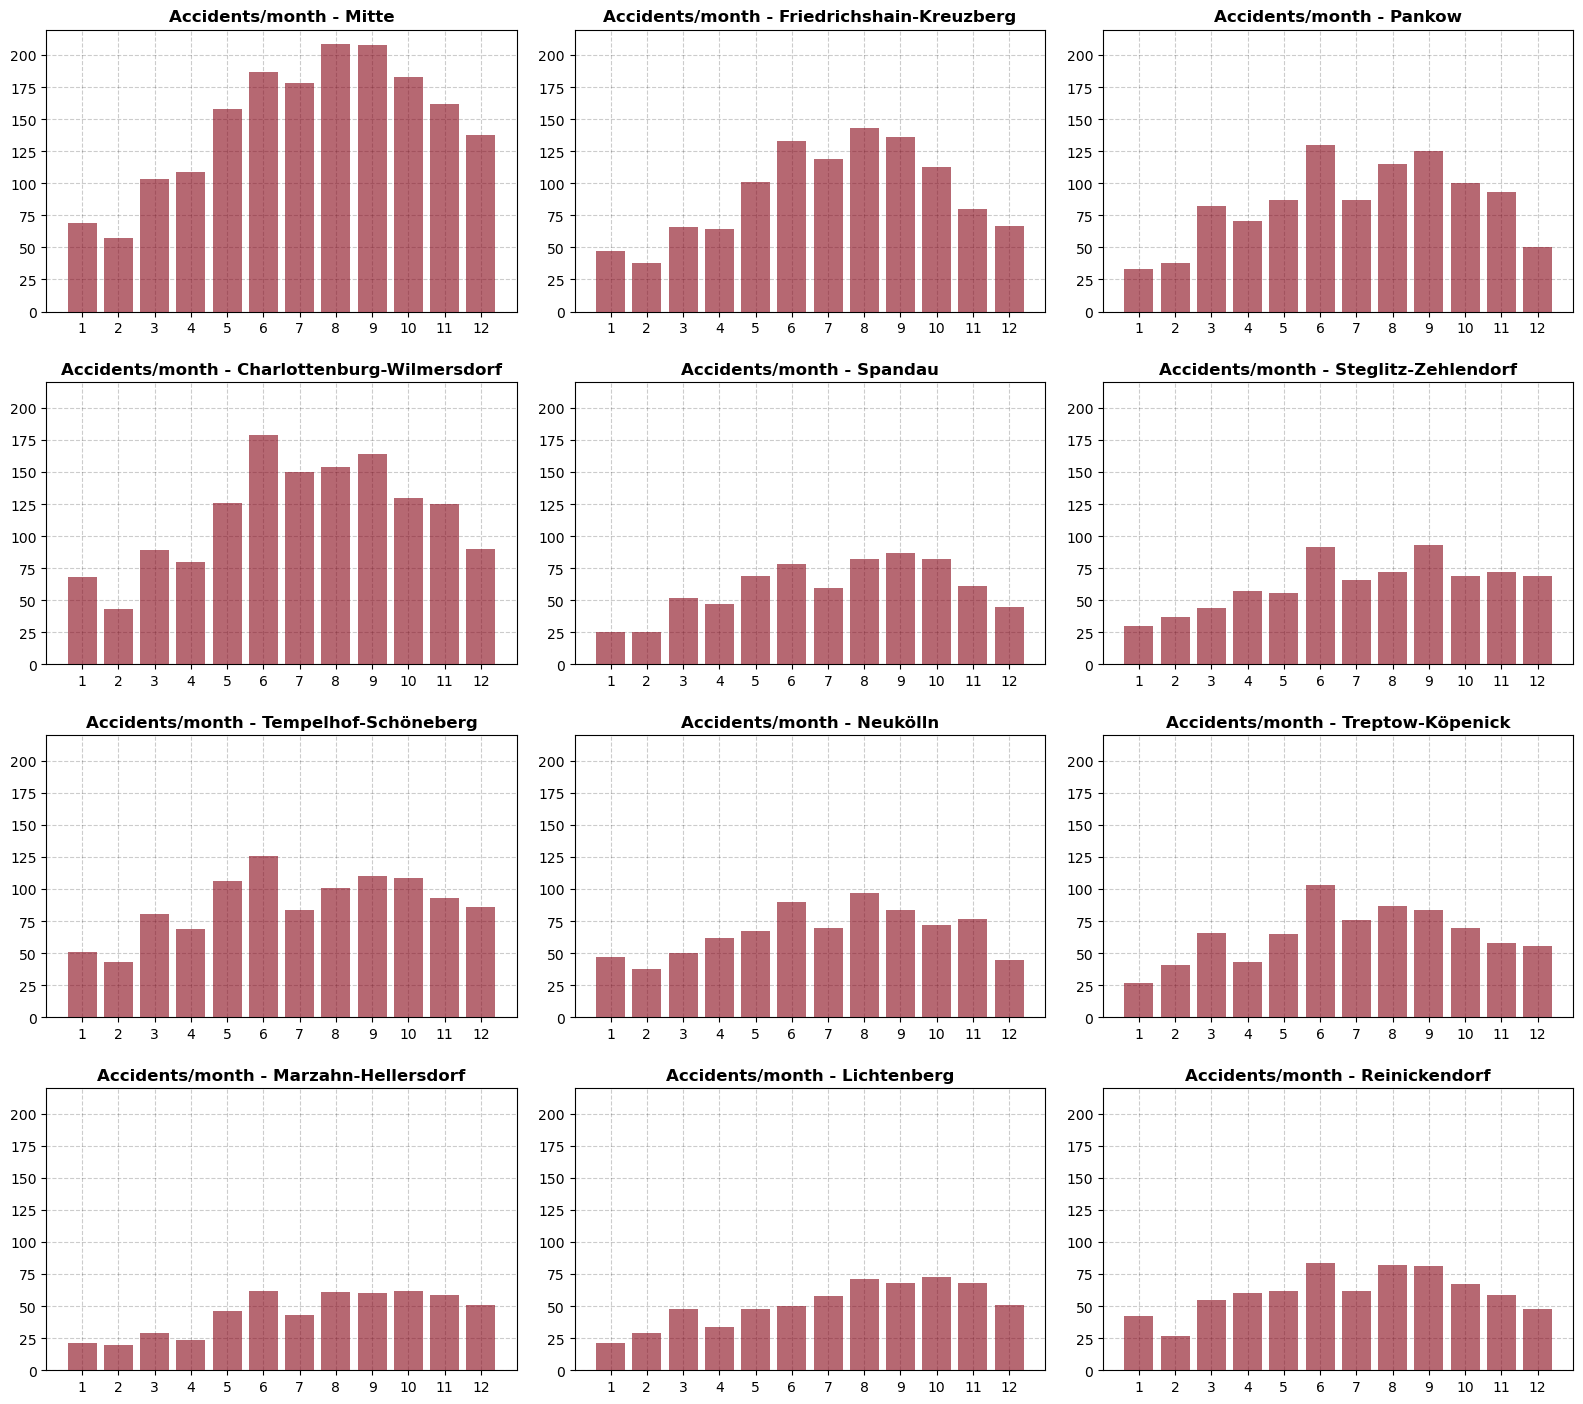

In [23]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3)

for p in range(rows*cols):
    # Customer Lifetime Value
    
    df_borough = data21[data21["bez"]==p+1]
    accidents_per_month = [len(df_borough[df_borough["umonat"]==monat]) for monat in month_number_list]
    
    ax[plot_coords[p]].set_title(f"Accidents/month - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--")
    ax[plot_coords[p]].bar(month_number_list, accidents_per_month, zorder=3, color="#860315", alpha=0.6)
    ax[plot_coords[p]].set_xticks(range(1,13,1))
    ax[plot_coords[p]].set_ylim([0,220])

plt.show()

## Location Data

In [24]:
len(data18.columns), len(data19.columns), len(data20.columns), len(data21.columns)

(25, 24, 24, 23)

# Research Questions

- more accidents on mondays? ✅
- more accidents on rainy/slippery days?
	- rebalancing unbalanced data!
- more severe accidents on rainy/slippery days?	
	- heavily imbalanced data!?
- check accident counts vs borough population
- more accidents at night?
	- normalize by traffic
- accidents with bicycle per borough
- more severe accidents when motorcycles involved?
- more severe accidents when trucks involved?

## More accidents on mondays?

In [25]:
weekdays_num = sorted(data_all["uwochentag"].unique())
weekdays = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

### Accidents per day and borough

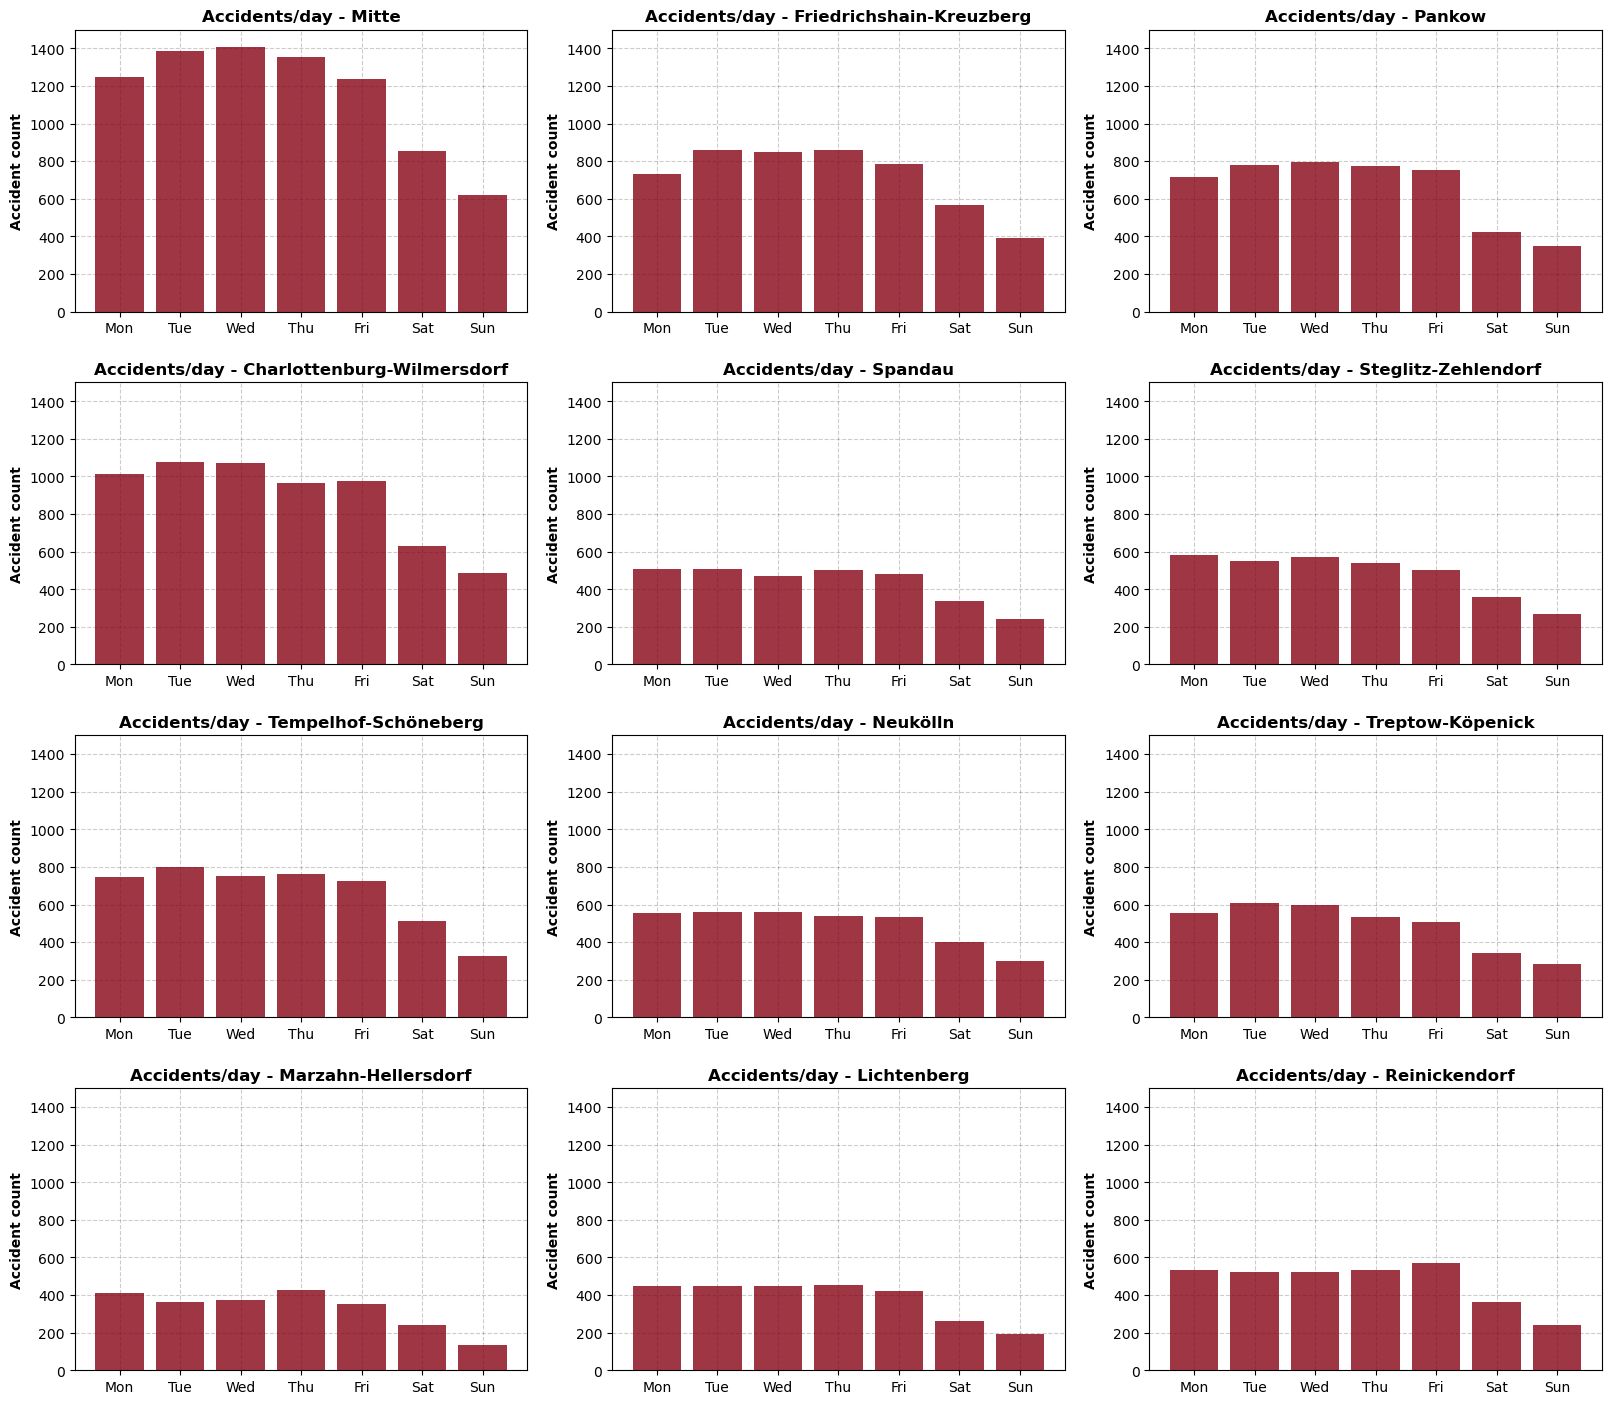

In [26]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

### PLOT CUMMULATIVE ACCIDENTS (TOTAL) PER DAY PER BOROUGH ###
fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3, w_pad = 3)

for p in range(rows*cols):
    df_borough = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df_borough[df_borough["uwochentag"]==day]) for day in weekdays_num]
    
    ax[plot_coords[p]].set_title(f"Accidents/day - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--")
    ax[plot_coords[p]].bar(weekdays_num, accidents_per_weekday, zorder=3, color="#860315", alpha=0.8)
    ax[plot_coords[p]].set_xticks(weekdays_num, weekdays)
    ax[plot_coords[p]].set_ylim([0,1500])
    ax[plot_coords[p]].set_ylabel("Accident count", weight="bold")

plt.show()

set monday as 100% and normalize following days

### Accidents per day and borough normalized

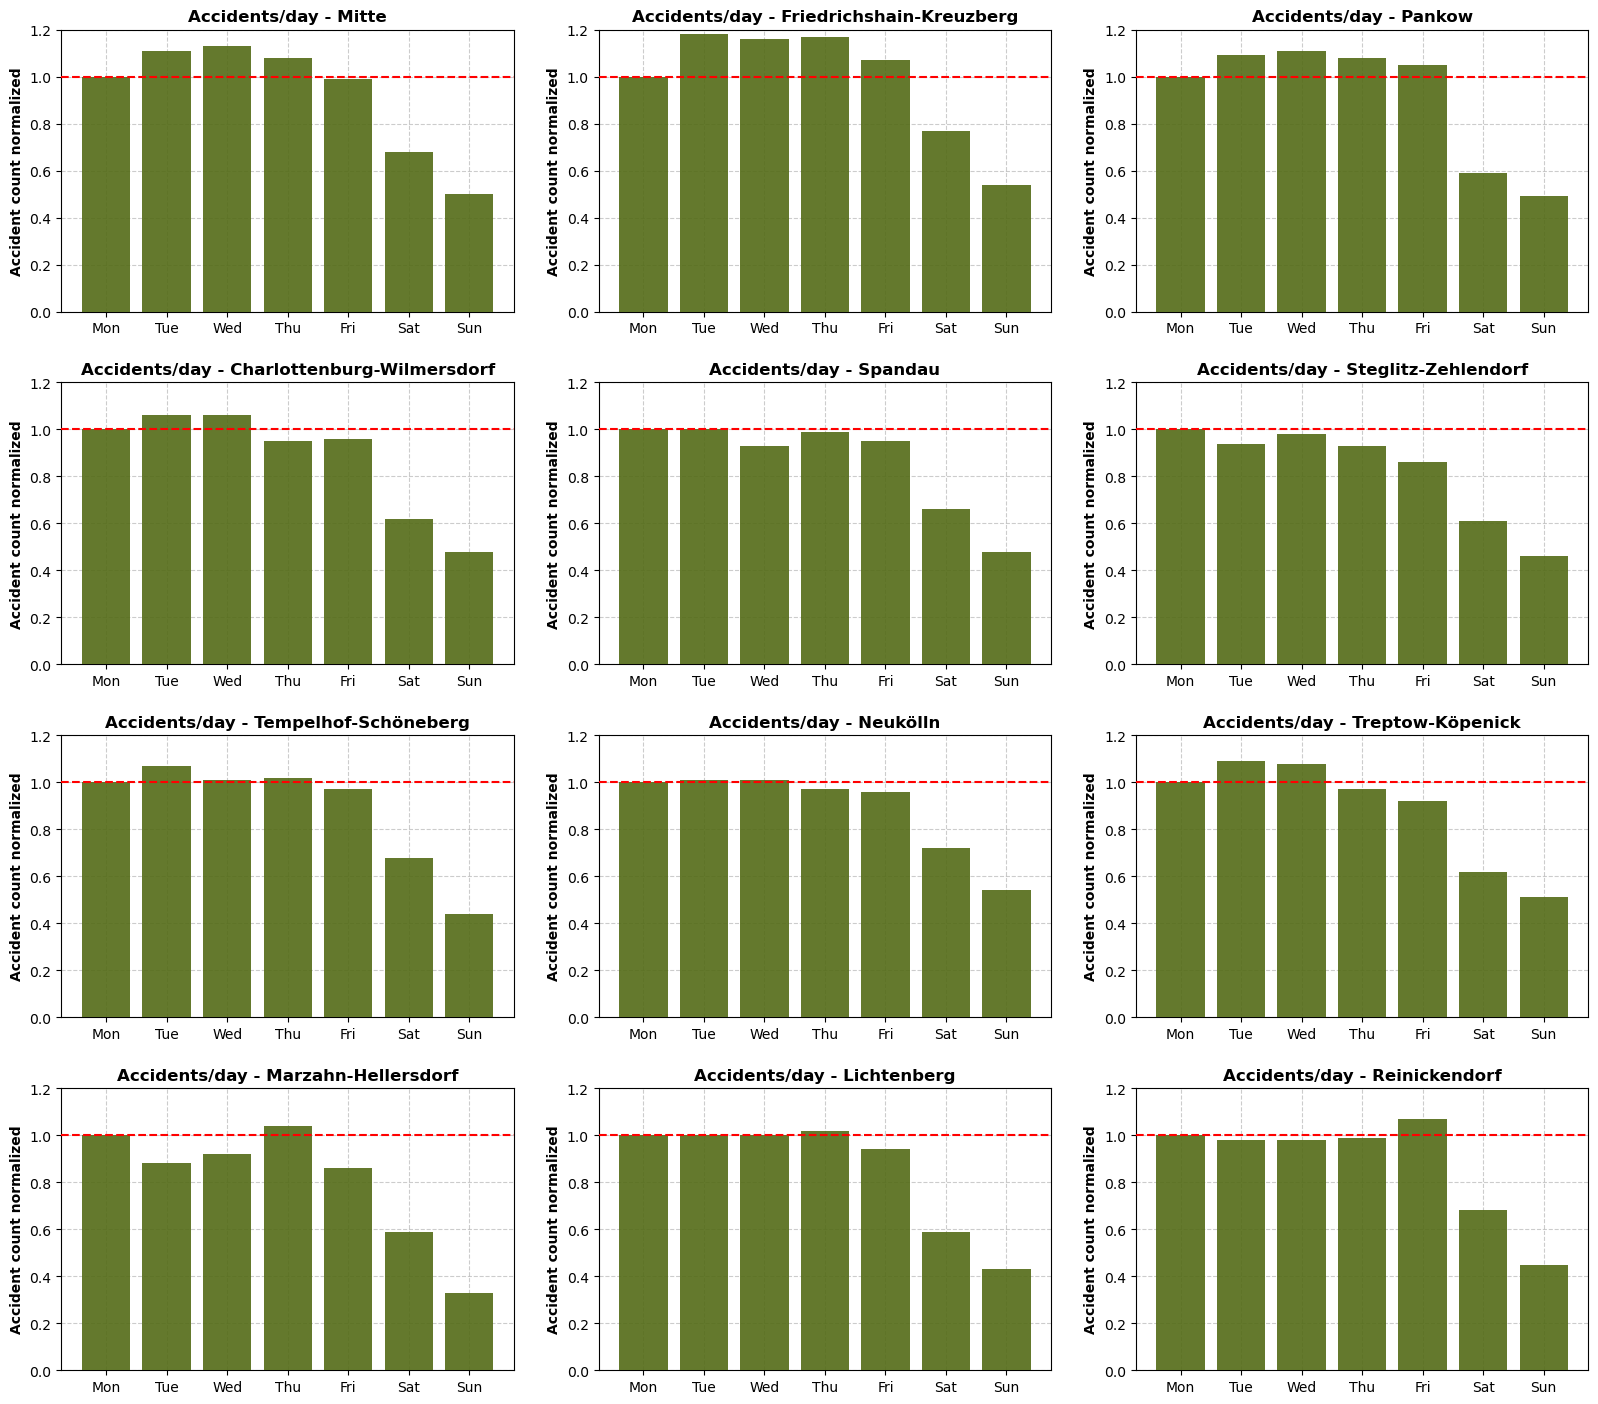

In [27]:
rows = 4
cols = 3
plot_coords = [(row,col) for row in range(rows) for col in range(cols)]

### PLOT CUMMULATIVE ACCIDENTS (RELATIVE; NORMALIZED ON MONDAYs) PER DAY PER BOROUGH ###
fig, ax = plt.subplots(rows, cols,figsize = (16,14))
fig.tight_layout(h_pad = 3, w_pad = 3)

for p in range(rows*cols):
    # Customer Lifetime Value
    
    df_borough = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df_borough[df_borough["uwochentag"]==day]) for day in weekdays_num]
    accidents_per_weekday_norm = [round(num/accidents_per_weekday[0],2) for num in accidents_per_weekday]
    
    ax[plot_coords[p]].set_title(f"Accidents/day - {borough_list[p]}", size=12, weight="bold")
    ax[plot_coords[p]].grid(color="k", alpha=0.2, ls="--")
    ax[plot_coords[p]].bar(weekdays_num, accidents_per_weekday_norm, zorder=3, color="#536b16", alpha=0.9)
    ax[plot_coords[p]].axhline(y=1, color='red', linestyle='--', zorder=4)
    ax[plot_coords[p]].set_xticks(weekdays_num, weekdays)
    ax[plot_coords[p]].set_ylim([0,1.2])
    ax[plot_coords[p]].set_ylabel("Accident count normalized", weight="bold")

plt.show()



### Overall Monday-normalized accident counts

In [29]:
accidents_per_weekday_summed = [0]*len(accidents_per_weekday_norm)

for p in range(rows*cols):
    df = data_all[data_all["bez"]==p+1]
    accidents_per_weekday = [len(df[df["uwochentag"]==day]) for day in weekdays_num]
    accidents_per_weekday_norm = [round(num/accidents_per_weekday[0],2) for num in accidents_per_weekday]
    
    for idx,_ in enumerate(accidents_per_weekday_norm):
        accidents_per_weekday_summed[idx] += accidents_per_weekday_norm[idx]
        
accidents_per_weekday_summed_norm = [round((num/accidents_per_weekday_summed[0])-1,3) 
                                     for num in accidents_per_weekday_summed]
accidents_per_weekday_summed_norm_str = [str(round(i*100,1))+" %" for i in accidents_per_weekday_summed_norm]
accidents_per_weekday_summed_norm_str

['0.0 %', '3.4 %', '3.1 %', '1.8 %', '-3.3 %', '-34.9 %', '-52.9 %']

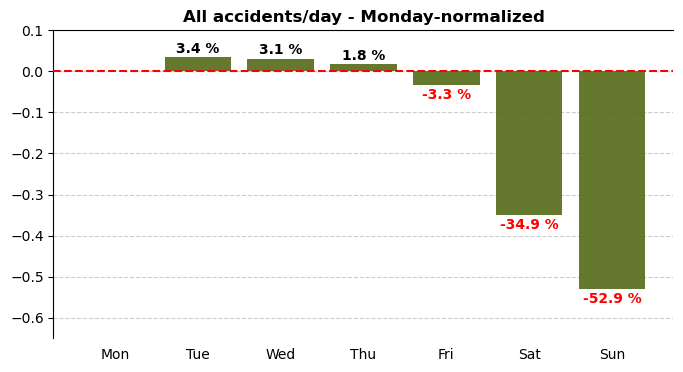

In [33]:
### PLOTTING ###
# GENERAL
fig, ax = plt.subplots(figsize=(8,4))
ax.set_title(f"All accidents/day - Monday-normalized", size=12, weight="bold")
#ax.grid(color="k", alpha=0.8, ls="-", axis="x")
ax.grid(color="k", alpha=0.2, ls="--", axis="y")

# PLOTTING DATA
x = weekdays_num
y = accidents_per_weekday_summed_norm

# PLOT
ax.bar(x, y, zorder=3, color="#536b16", alpha=0.9)
ax.axhline(y=0, color='red', linestyle='--', zorder=4)

# AXIS HANDLING
ax.set_xticks(weekdays_num, weekdays)
ax.set_ylim([-0.65, 0.1])

#ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
#ax.spines['left'].set_visible(False)

ax.tick_params(axis="x", bottom=False)

# ANNOTATIONS
strings = accidents_per_weekday_summed_norm_str
y_positions = accidents_per_weekday_summed_norm
x_positions = weekdays_num
anot_colors = ["k", "k", "k", "k", "r", "r", "r"]
for i in range(len(x_positions)):
    if i == 0:
        pass
    elif y_positions[i] > 0:
        spacer = 0.02
        ax.annotate(strings[i], (x_positions[i], y_positions[i]+spacer), 
                    ha="center", va="center", weight="bold", color=anot_colors[i])
    else:
        spacer = -0.025
        ax.annotate(strings[i], (x_positions[i], y_positions[i]+spacer), 
                    ha="center", va="center", weight="bold", color=anot_colors[i])

# SAVE FIG
#plt.savefig("all_accidents_per_day_monday_normalized.jpg", dpi=300, bbox_inches="tight")

plt.show()

- Monday is not the day with most accidents!
- on Tuesdays happen the most accidents on an overall averaged basis (+3.4% compared to Monday)
- closely behind is Wednesday with +3.1%
- on weekends substantially fewer accidents happen
    - most likely due to significantly less traffic
- maybe being able to rest on the weekend people are a tiny bit less likely to be involved / cause accidents on Mondays?

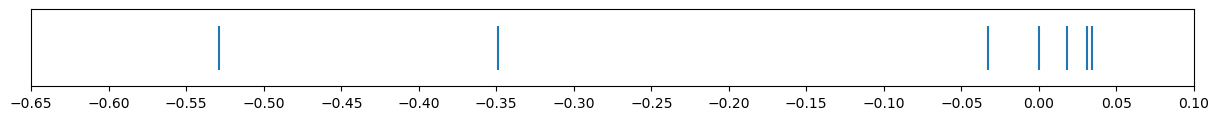

In [34]:
x = accidents_per_weekday_summed_norm
y = [1]*len(accidents_per_weekday_summed_norm)

fig, ax = plt.subplots(figsize=(15,1))
plt.scatter(x,y, marker="|", s=1000)
ax.get_yaxis().set_visible(False) # set y-axis to invisible
ax.set_xticks(np.arange(-0.65, 0.11, 0.05))

plt.show()

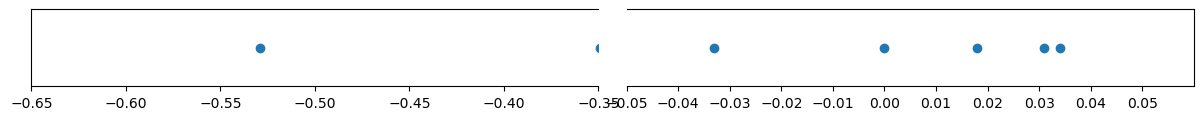

In [35]:
### PLOT WITH BROKEN X-AXIS ###

f,(ax,ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,1))
f.subplots_adjust(wspace=0.05)

# plot the same data on both axes
ax.scatter(x, y)
ax2.scatter(x, y)

ax.set_xlim(-0.65, -0.35)
ax.set_xticks(np.arange(-0.65, -0.35, 0.05))
ax2.set_xlim(-0.05, 0.06)
ax2.set_xticks(np.arange(-0.05, 0.06, 0.01))

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax.yaxis.tick_left()
#ax.tick_params(labelright='off')
#ax2.yaxis.tick_right()
ax.get_yaxis().set_visible(False) # set y-axis to invisible
ax2.get_yaxis().set_visible(False) # set y-axis to invisible

plt.show()

## More accidents on rainy/slippery days?

### Split df into data for dry, wet, slippery

In [36]:
#0 = trocken // dry
#1 = nass/feucht/schlüpfrig // wet/damp/slippery
#2 = winterglatt // winter slipperiness

data21["ustrzustand"].value_counts().sort_index()

0    8407
1    2694
2     166
Name: ustrzustand, dtype: int64

In [37]:
data_all_dry = data_all[data_all["ustrzustand"]==0].reset_index(drop=True)
data_all_wet = data_all[data_all["ustrzustand"]==1].reset_index(drop=True)
data_all_slippery = data_all[data_all["ustrzustand"]==2].reset_index(drop=True)

len(data_all_dry), len(data_all_wet), len(data_all_slippery)

(38670, 11152, 296)

### Rain / ice days per year data

[weather data berlin 2018-2020](https://www.weatheronline.de/weather/maps/city?LANG=de&PLZ=_____&PLZN=_____&WMO=10384&CONT=dldl&R=0&LEVEL=162&REGION=0001&LAND=DL&MOD=tab&ART=EIT&NOREGION=0)

In [38]:
# Data for weather station in Berlin-Tempelhof is used representatively
# as I found no data generalized for all Berlin

# days with precipitation > 0.1mm
rainy_days_per_year = [[2018, 75], [2019, 108], [2020, 86], [2021, 177]]
rainy_days_per_year_median = np.median([tup[1] for tup in rainy_days_per_year])
rainy_days_per_year_mean = np.mean([tup[1] for tup in rainy_days_per_year])

# Ice days are the days of the year when both the nighttime minimum temperature 
# and the daytime maximum temperature are below 0°C.
# Recorded icey days have been multiplied by two to account for snowy days 
# in a rather crude way as data was very lackluster for snowy days.
slippery_days_per_year = [[2018, 10*2], [2019, 4*2], [2020, 1*2], [2021, 15*2]]
slippery_days_per_year_median = np.median([tup[1] for tup in slippery_days_per_year])
slippery_days_per_year_mean = np.mean([tup[1] for tup in slippery_days_per_year])

# Define dry days as the difference between total number of years (=365, except for 2020 with 366 as leap year)
# and rainy & icey days
dry_days_per_year = [[2018, 365-10-75], [2019, 365-4-108], [2020, 366-1-86], [2021, 365-15-177]]
dry_days_per_year_median = np.median([tup[1] for tup in dry_days_per_year])
dry_days_per_year_mean = np.mean([tup[1] for tup in dry_days_per_year])


### Accidents per year with varying conditions (dry / wet / icey)

In [44]:
days_per_year_wet = [[2018, 75], [2019, 108], [2020, 86], [2021, 177]]
days_per_year_slippery = [[2018, 20], [2019, 8], [2020, 2], [2021, 30]]
days_per_year_dry = [[2018, 280], [2019, 253], [2020, 279], [2021, 173]]

for idx, year in enumerate([tup[0] for tup in rainy_days_per_year]):
    
    #if year = 2020:
        #daysinyear = 366
    #else:
        #daysinyear = 365
    
    wet = data_all_wet[data_all_wet["ujahr"]==year]
    days_per_year_wet[idx].append(len(wet))
    days_per_year_wet[idx].append(round(len(wet) / days_per_year_wet[idx][1],1))
    
    slippery = data_all_slippery[data_all_slippery["ujahr"]==year]
    days_per_year_slippery[idx].append(len(slippery))
    days_per_year_slippery[idx].append(round(len(slippery) / days_per_year_slippery[idx][1],1))
    
    dry = data_all_dry[data_all_dry["ujahr"]==year]
    days_per_year_dry[idx].append(len(dry))
    days_per_year_dry[idx].append(round(len(dry) / days_per_year_dry[idx][1],1))
    
print("<<< WET DAYS >>>")
print(f"2018 - {days_per_year_wet[0][1]} days - {days_per_year_wet[0][2]} accidents - {days_per_year_wet[0][3]} accidents/day")
print(f"2019 - {days_per_year_wet[1][1]} days - {days_per_year_wet[1][2]} accidents - {days_per_year_wet[1][3]} accidents/day")
print(f"2020 - {days_per_year_wet[2][1]} days - {days_per_year_wet[2][2]} accidents - {days_per_year_wet[2][3]} accidents/day")
print(f"2021 - {days_per_year_wet[3][1]} days - {days_per_year_wet[3][2]} accidents - {days_per_year_wet[3][3]} accidents/day")
print()
print("<<< SLIPPERY DAYS >>>")
print(f"2018 - {days_per_year_slippery[0][1]} days - {days_per_year_slippery[0][2]} accidents - {days_per_year_slippery[0][3]} accidents/day")
print(f"2019 - {days_per_year_slippery[1][1]} days - {days_per_year_slippery[1][2]} accidents - {days_per_year_slippery[1][3]} accidents/day")
print(f"2020 - {days_per_year_slippery[2][1]} days - {days_per_year_slippery[2][2]} accidents - {days_per_year_slippery[2][3]} accidents/day")
print(f"2021 - {days_per_year_slippery[3][1]} days - {days_per_year_slippery[3][2]} accidents - {days_per_year_slippery[3][3]} accidents/day")
print()
print("<<< DRY DAYS >>>")
print(f"2018 - {days_per_year_dry[0][1]} days - {days_per_year_dry[0][2]} accidents - {days_per_year_dry[0][3]} accidents/day")
print(f"2019 - {days_per_year_dry[1][1]} days - {days_per_year_dry[1][2]} accidents - {days_per_year_dry[1][3]} accidents/day")
print(f"2020 - {days_per_year_dry[2][1]} days - {days_per_year_dry[2][2]} accidents - {days_per_year_dry[2][3]} accidents/day")
print(f"2021 - {days_per_year_dry[3][1]} days - {days_per_year_dry[3][2]} accidents - {days_per_year_dry[3][3]} accidents/day")

<<< WET DAYS >>>
2018 - 75 days - 2540 accidents - 33.9 accidents/day
2019 - 108 days - 3190 accidents - 29.5 accidents/day
2020 - 86 days - 2728 accidents - 31.7 accidents/day
2021 - 177 days - 2694 accidents - 15.2 accidents/day

<<< SLIPPERY DAYS >>>
2018 - 20 days - 64 accidents - 3.2 accidents/day
2019 - 8 days - 45 accidents - 5.6 accidents/day
2020 - 2 days - 21 accidents - 10.5 accidents/day
2021 - 30 days - 166 accidents - 5.5 accidents/day

<<< DRY DAYS >>>
2018 - 280 days - 11048 accidents - 39.5 accidents/day
2019 - 253 days - 10154 accidents - 40.1 accidents/day
2020 - 279 days - 9061 accidents - 32.5 accidents/day
2021 - 173 days - 8407 accidents - 48.6 accidents/day
